<a href="https://colab.research.google.com/github/andreYoo/Time-series-analysis-anomaly-detection/blob/main/Deep_times_series_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd # 판다스 호출 
import numpy as np  # 넘파이 호출 
import torch 
import statsmodels.api as sm # statsmodels 호출 
import seaborn as sns # 그래프를 그리기위한 Seaborn 호출 
from statsmodels.tsa.seasonal import seasonal_decompose # 데이터 필터 라이러리 호출 
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install arff2pandas==1.0.1
from arff2pandas import a2p
# train_data = arff.loadarff('/content/drive/MyDrive/study/ECG5000/ECG5000_TRAIN.arff')
# train = pd.DataFrame(train_data)

# test_data = arff.loadarff('/content/drive/MyDrive/study/ECG5000/ECG5000_TEST.arff')
# test = pd.DataFrame(test_data)w

with open('/content/drive/MyDrive/study/ECG5000/ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)
with open('/content/drive/MyDrive/study/ECG5000/ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [27]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [28]:
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

In [29]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
1875,-0.515724,-1.563554,-2.039355,-2.898245,-3.326277,-3.170517,-2.548977,-1.911863,-1.699591,-1.372376,-1.020362,-0.922213,-0.966101,-0.978622,-0.908839,-0.891281,-0.848366,-0.856182,-0.839674,-0.876918,-0.884090,-0.859448,-0.857008,-0.868380,-0.848084,-0.831820,-0.848542,-0.881871,-0.914590,-0.959541,-0.882972,-0.850895,-0.925463,-0.910213,-0.887208,-0.949472,-0.939005,-0.886993,-0.811330,-0.803310,...,1.127099,1.329905,1.462641,1.489241,1.471211,1.413858,1.337590,1.279013,1.168654,1.107210,0.968192,0.831306,0.671466,0.592054,0.601736,0.602660,0.575638,0.628223,0.643105,0.605819,0.649243,0.701145,0.702836,0.767408,0.724568,0.800958,0.789068,0.913059,1.228823,1.666924,1.858426,1.846428,1.997877,1.932873,1.515578,1.082825,0.833412,1.112503,0.809461,1
487,-1.926975,-3.202321,-3.563273,-4.052199,-3.923935,-3.445560,-2.188009,-1.502844,-1.386959,-0.850036,-0.349304,-0.293085,-0.458592,-0.264808,-0.227025,-0.415025,-0.326104,-0.308613,-0.336898,-0.318364,-0.312430,-0.290440,-0.295316,-0.249989,-0.318646,-0.361256,-0.239630,-0.245579,-0.418083,-0.311350,-0.341749,-0.281837,-0.316936,-0.329075,-0.180566,-0.352081,-0.296351,-0.115320,-0.172687,-0.158302,...,1.887204,1.837928,1.848501,1.749516,1.507207,1.418692,1.176951,0.835518,0.784116,0.544970,0.076138,-0.117321,-0.211492,-0.163972,-0.181614,-0.214346,-0.152542,-0.222816,-0.166882,-0.226478,-0.249343,-0.234265,-0.262405,-0.294147,-0.284424,-0.317254,-0.160417,0.170303,0.761621,1.364653,1.433619,1.205813,0.749533,0.128525,-0.796649,-1.455348,-1.631959,-1.303783,-1.446336,1
2421,0.077462,-2.209479,-3.535134,-4.665829,-4.281586,-3.217774,-2.010526,-1.510237,-1.312390,-0.430909,-0.289843,-0.506270,-0.249146,-0.266946,-0.400171,-0.321693,-0.202644,-0.057628,-0.452864,-0.655358,-0.507753,-0.487986,-0.391568,-0.463196,-0.409911,-0.412647,-0.692174,-0.538243,-0.550652,-0.454352,-0.607019,-0.723087,-0.610996,-0.488185,-0.705533,-0.849366,-0.899428,-0.806360,-0.733559,-0.609290,...,1.158190,1.601062,2.097801,2.201393,1.977577,1.859818,1.925356,1.697352,1.129393,0.976534,0.740752,0.047082,-0.135876,-0.383724,-0.306727,-0.270920,-0.513780,-0.466575,-0.315927,-0.421448,-0.407559,-0.291907,-0.246502,-0.367585,-0.372237,-0.207073,-0.109410,-0.149136,0.074514,0.842265,1.233373,0.865505,0.793086,0.442236,-0.134369,-0.003038,0.472147,0.978863,-0.661881,1
2051,3.279402,1.014344,-1.426537,-3.605481,-4.517397,-3.837551,-2.649532,-1.407748,-1.068023,-0.489046,0.547282,0.745563,0.673006,0.694532,0.741441,0.514460,0.587786,0.749429,0.541841,0.533402,0.408923,0.481332,0.306213,0.282587,0.204935,0.176757,0.149203,0.091870,-0.034247,-0.050162,-0.268738,-0.284639,-0.308189,-0.500110,-0.485943,-0.517859,-0.476606,-0.550523,-0.517302,-0.534807,...,1.249263,1.567595,1.755620,1.718803,1.683368,1.436436,1.299959,0.955440,0.562811,0.150114,-0.434847,-0.869522,-1.025836,-1.100807,-1.170299

In [30]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

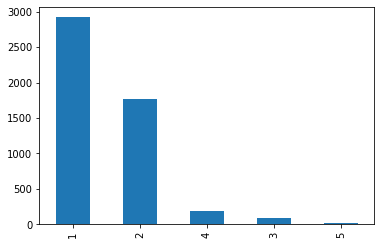

In [37]:
df.target.value_counts().plot.bar()

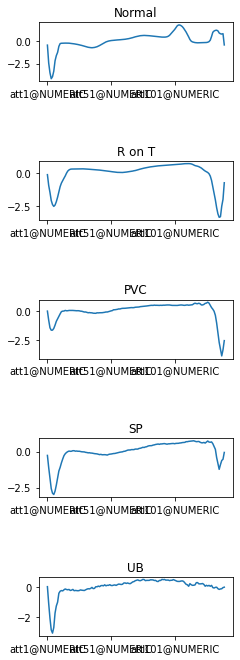

In [92]:
fig, axes = plt.subplots(5)
fig.tight_layout()
for i in range(5):
  _df = df[df.target == str(i+1)].drop(labels='target', axis=1)
  _df.median().plot(ax=axes[i],title=class_names[i],figsize=(3,10))

In [85]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [54]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
RANDOM_SEED = 0

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)
val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

In [59]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [60]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [62]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [63]:
class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    return self.output_layer(x)

In [64]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [65]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [68]:
import copy
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [69]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=150
)

Epoch 1: train loss 62.17297584690523 val loss 54.34961458277784


KeyboardInterrupt: ignored

In [ ]:
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

In [72]:
!gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
model = torch.load('model.pth',map_location=torch.device('cpu'))
model = model.to('cpu')

Downloading...
From: https://drive.google.com/uc?id=1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
To: /content/model.pth
100% 3.98M/3.98M [00:00<00:00, 158MB/s]


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [73]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


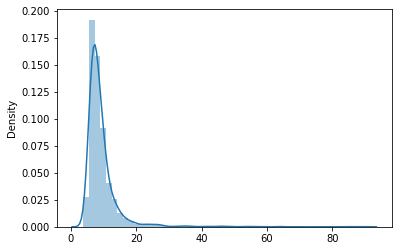

In [74]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);

In [75]:
THRESHOLD = 26

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


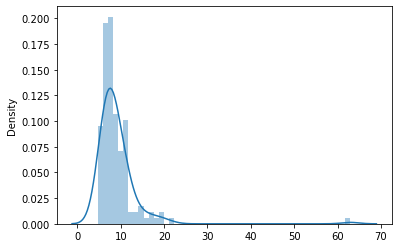

In [76]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [77]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 144/145


In [78]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

In [79]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 1/145
